This code analyzes the clinical data of 138 patients with ductal squamous carcinoma.I trained two classifiers—Random Forest and K-Nearest Neighbors (KNN)—to predict the patients’ vital status based on their clinical data. Finally, I used the models to predict the vital status for the four patients with missing information.I visualized the data composition and the feature importance to better understand the distribution of the clinical variables and which features most influenced the predictions.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import cross_validate

import scipy
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, RocCurveDisplay, roc_auc_score

import time
import math

In [2]:
clinical = pd.read_csv(
    "clinical.csv",
    sep=";",          # the file uses semicolons as separators
    decimal=",",      # numbers use comma as decimal point (e.g., 4,5 instead of 4.5)
    engine="python"   # python engine handles complex delimiters better
)

In [65]:
print(clinical['participant_country'].unique())

['United States' 'Cada' 'Other' 'Poland' 'Russia' 'Chi' 'Bulgaria'
 'South Wales' 'Denmark' 'Serbia' 'India' 'Iraq']


In [67]:
pip install geopandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 5.8 MB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 5.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [geopandas]/3 [geopandas]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd

# ----------------------------
# Step 1: Try to read the CSV with multiple options
# ----------------------------

# Option: semicolon-separated, skip bad lines
try:
    clinical = pd.read_csv(
        "clinical.csv",
        sep=";",               # adjust to your file: "," or "\t" if needed
        engine="python",
        on_bad_lines='skip'    # skip lines that are malformed
    )
except Exception as e:
    print("Error reading CSV:", e)

print("Initial shape:", clinical.shape)
print(clinical.head())

# ----------------------------
# Step 2: Inspect column names
# ----------------------------
print("Columns:", clinical.columns.tolist())

# Strip whitespace from column names
clinical.columns = [c.strip() for c in clinical.columns]

# ----------------------------
# Step 3: Optional - inspect rows with too many/few fields
# ----------------------------
# Manually detect problematic rows
with open("clinical.csv", "r") as f:
    for i, line in enumerate(f):
        fields = line.strip().split(";")  # adjust delimiter
        if len(fields) != len(clinical.columns):
            print(f"Line {i} has {len(fields)} fields:", fields)
        if i > 20:  # only check first 20 lines
            break

# ----------------------------
# Step 4: Fix known issues in column values
# ----------------------------
country_mapping = {
    "Cada": "Canada",
    "Chi": "China",
    "South Wales": "United Kingdom",
    "Other": None
}
if "participant_country" in clinical.columns:
    clinical["participant_country"] = clinical["participant_country"].replace(country_mapping)
    clinical = clinical.dropna(subset=["participant_country"])

# ----------------------------
# Step 5: Check data types
# ----------------------------
print(clinical.dtypes)


Initial shape: (140, 25)
     case_id histology_diagnosis  age     sex   race participant_country  \
0  C3L-00017                PDAC   69    Male  White       United States   
1  C3L-00102                PDAC   42    Male  White       United States   
2  C3L-00189                PDAC   68  Female    NaN                Cada   
3  C3L-00277                PDAC   69    Male  White               Other   
4  C3L-00401                PDAC   62  Female    NaN                Cada   

  tumor_site tumor_size_cm  tumor_necrosis lymph_vascular_invasion  ...  \
0       head           4,5  Not identified          Not identified  ...   
1       head             3  Not identified                 Present  ...   
2       head           2,7  Not identified          Not identified  ...   
3       tail             5  Not identified          Not identified  ...   
4       body           2,8  Not identified                 Present  ...   

                                      residual_tumor tumor_stage_pa

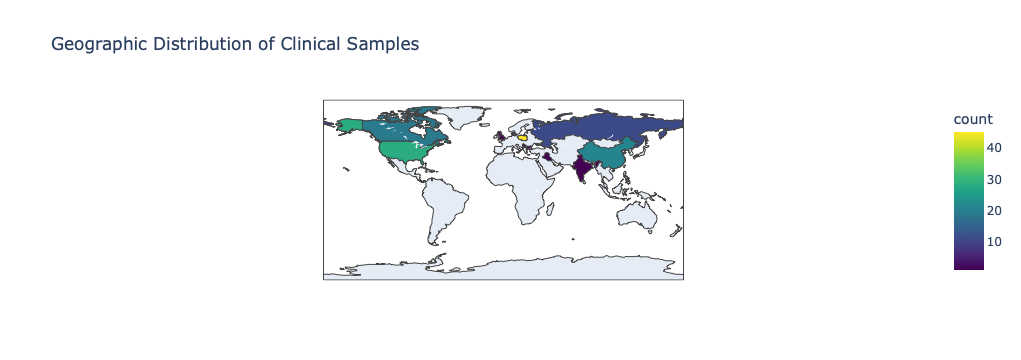

In [17]:
import pandas as pd
import plotly.express as px

#clinical = pd.read_csv("clinical.csv")

country_mapping = {
    "Cada": "Canada",
    "Chi": "China",
    "South Wales": "United Kingdom",
    "Other": None
}
clinical["participant_country"] = clinical["participant_country"].replace(country_mapping)
clinical = clinical.dropna(subset=["participant_country"])

# Count samples per country
country_counts = clinical["participant_country"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    color_continuous_scale="viridis",
                    title="Geographic Distribution of Clinical Samples")
fig.show()



In [7]:
import geopandas as gpd
import geodatasets
import pandas as pd
import matplotlib.pyplot as plt


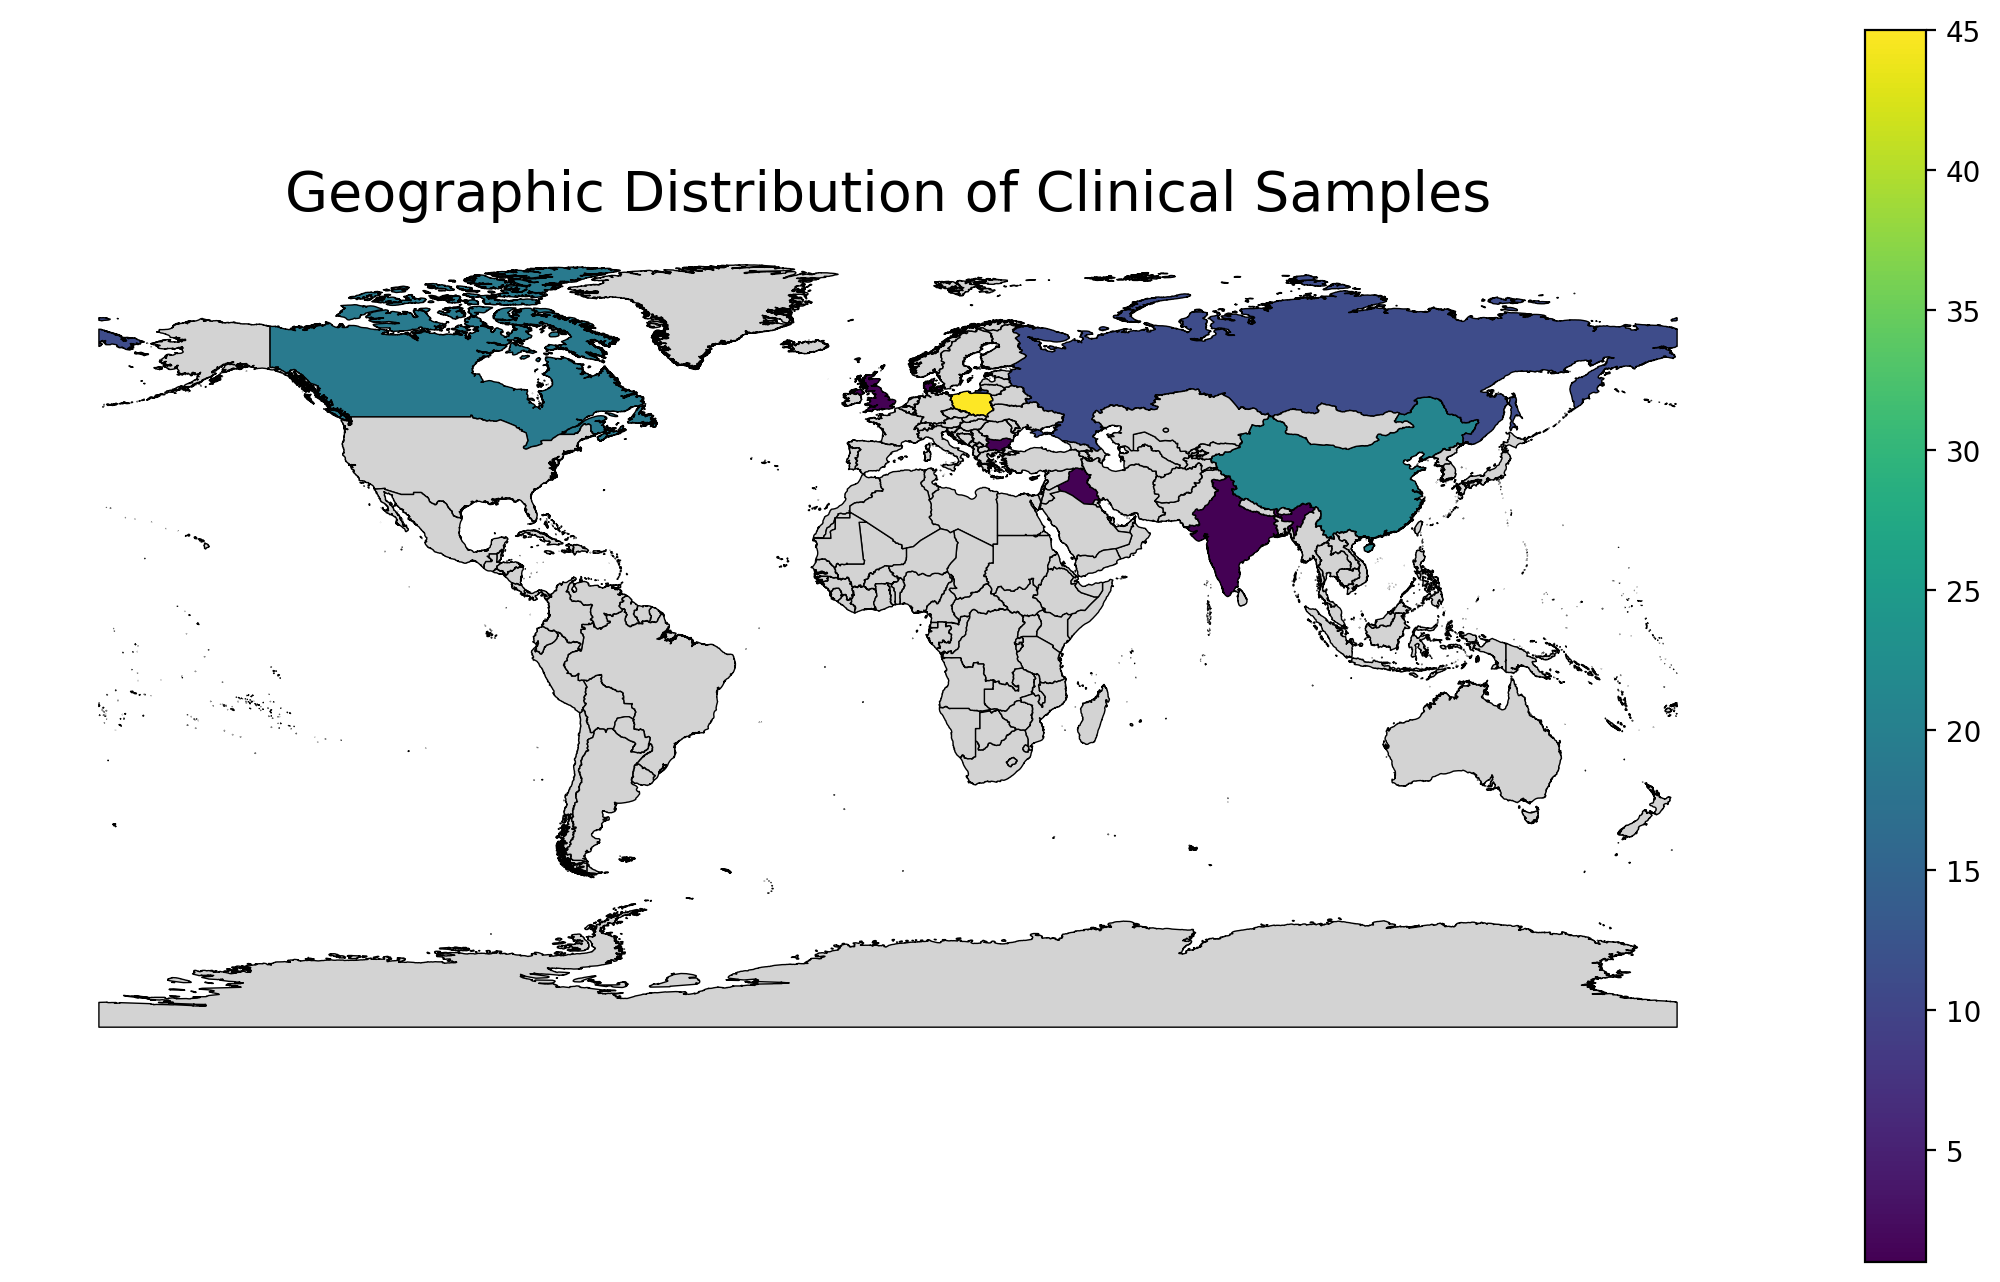

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# --- Load clinical data ---
clinical = pd.read_csv("clinical.csv", sep=";", engine="python", on_bad_lines='skip')

# Fix country names
country_mapping = {
    "Cada": "Canada",
    "Chi": "China",
    "South Wales": "United Kingdom",
    "Other": None
}
clinical["participant_country"] = clinical["participant_country"].replace(country_mapping)
clinical = clinical.dropna(subset=["participant_country"])

# Count samples per country
country_counts = clinical["participant_country"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

# --- Load world map ---
world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")

# Merge clinical counts
world = world.merge(country_counts, how="left", left_on="name", right_on="country")

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the map
world.plot(
    column="count",
    cmap="viridis",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgray", "label": "No data"}
)

# Move the colorbar to the right
sm = plt.cm.ScalarMappable(cmap="viridis", 
                           norm=plt.Normalize(vmin=world["count"].min(), vmax=world["count"].max()))
sm._A = []  # dummy array for ScalarMappable
#cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Number of Samples", fontsize=12)

# Title and remove axes
ax.set_title("Geographic Distribution of Clinical Samples", fontsize=20)
ax.axis("off")

# Save figure
plt.savefig("clinical_world_map.png", dpi=300, bbox_inches='tight')
plt.show()




In [21]:
import geopandas as gpd

world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
print(world.columns)


Index(['name', 'ISO3166-1-Alpha-3', 'ISO3166-1-Alpha-2', 'geometry'], dtype='object')


In [11]:
!pip install geodatasets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geodatasets]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


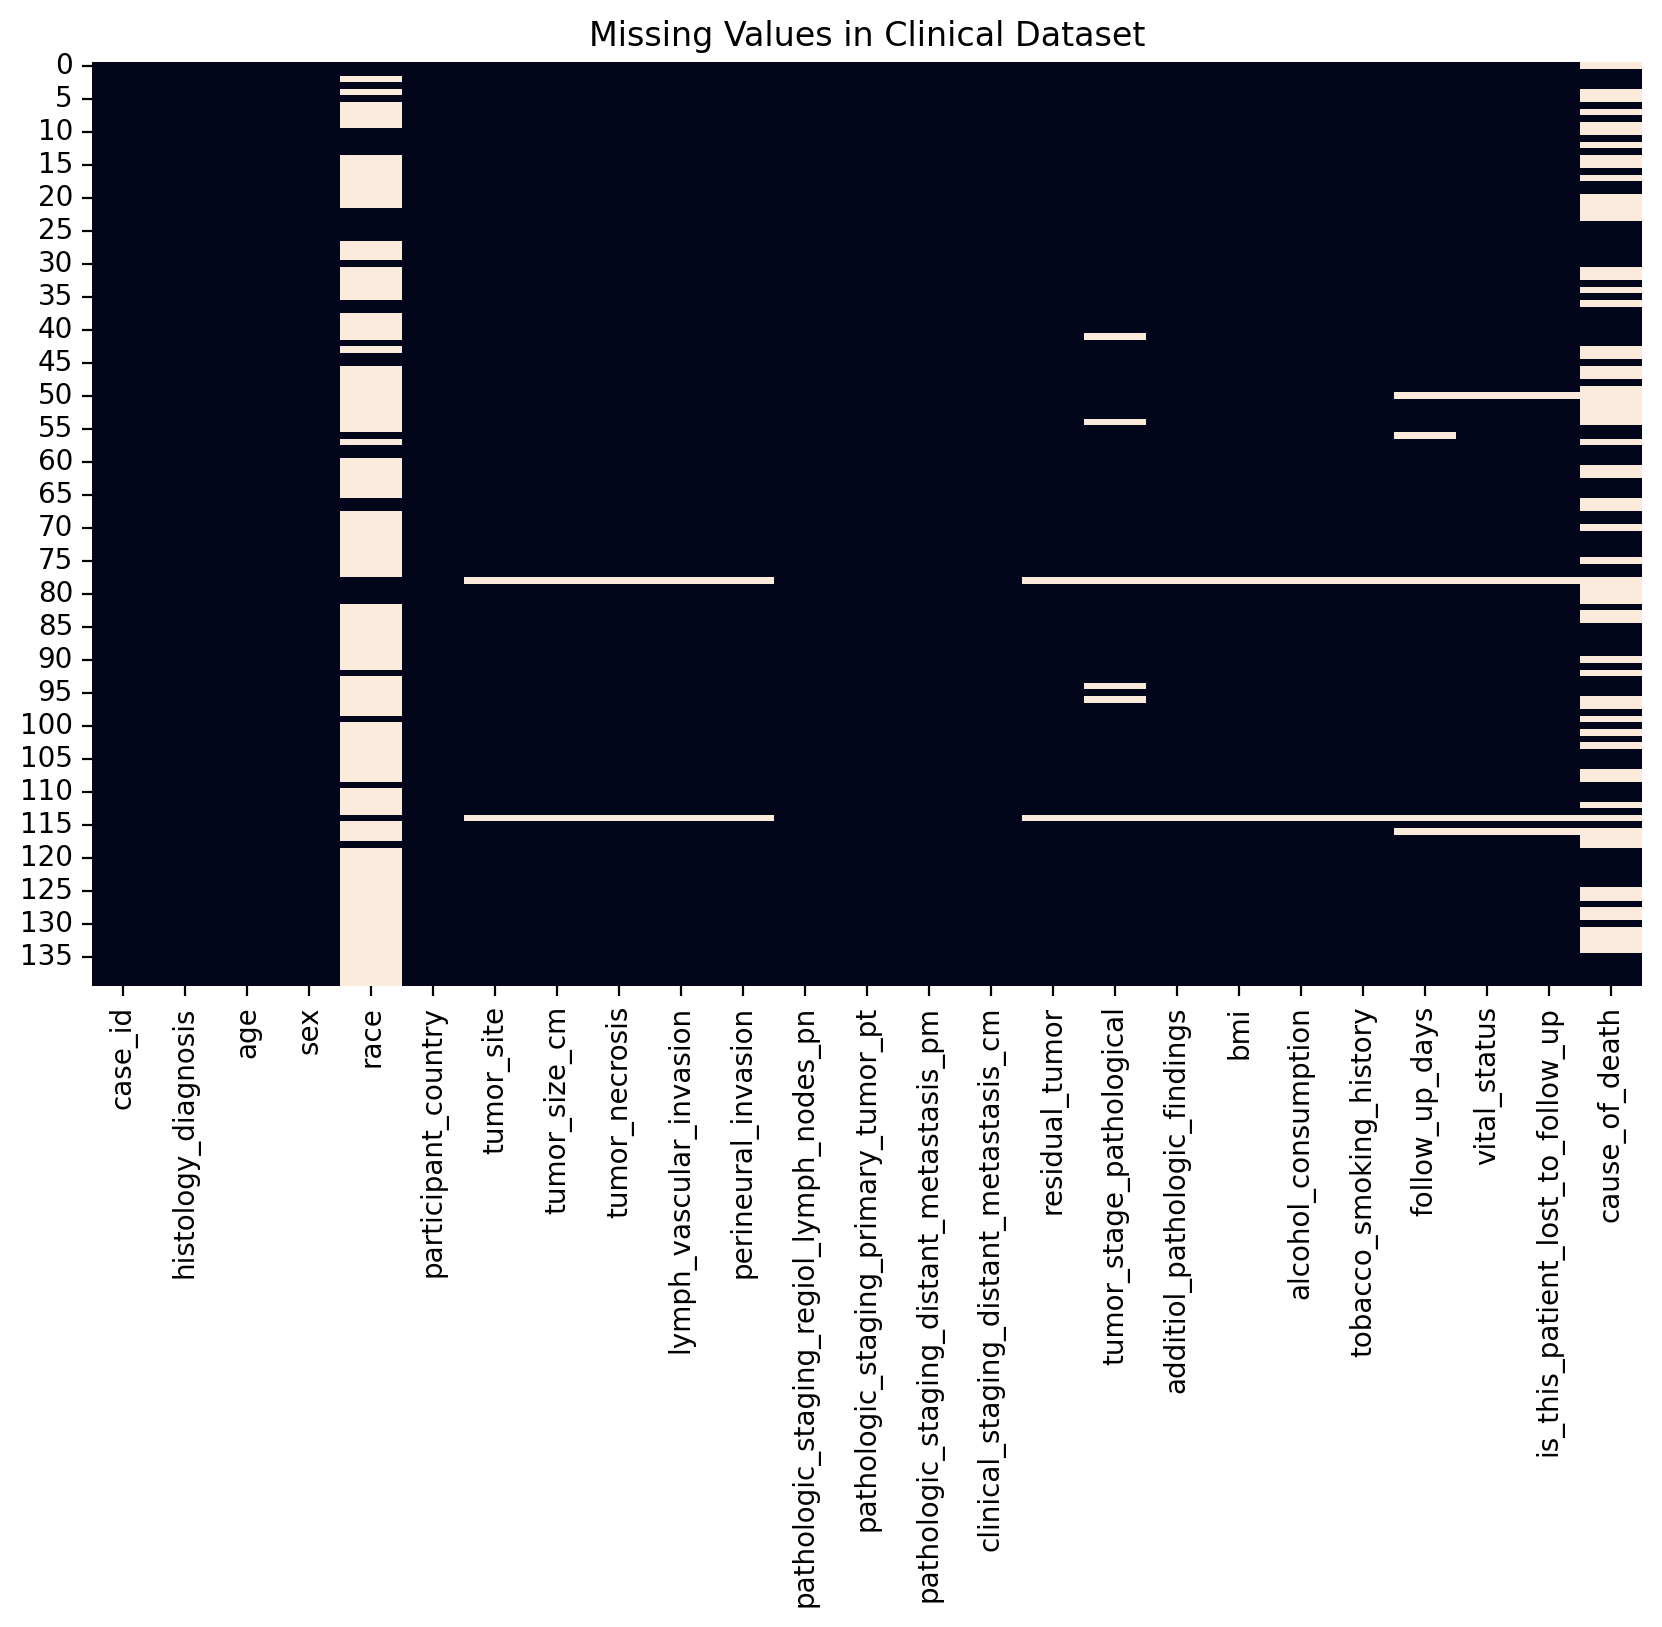

In [3]:
plt.figure(figsize=(10,6))
sns.heatmap(clinical.isnull(), cbar=False)
plt.title("Missing Values in Clinical Dataset")
plt.show()

In [6]:
# Columns to drop
cols_to_drop = [
    'race',
    'histology_diagnosis',
    'pathologic_staging_regiol_lymph_nodes_pn',
    'pathologic_staging_primary_tumor_pt',
    'pathologic_staging_distant_metastasis_pm',
    'clinical_staging_distant_metastasis_cm',
    'residual_tumor',
    'tumor_stage_pathological',
    'is_this_patient_lost_to_follow_up',
    'cause_of_death'
]

# Drop the columns
clinical = clinical.drop(columns=cols_to_drop, errors='ignore')

# Save if needed
clinical.to_csv('clinical_cleaned.csv', index=False)

clinical.head()

case_id  age     sex participant_country tumor_site  tumor_size_cm  \
0  C3L-00017   69    Male       United States       head            4.5   
1  C3L-00102   42    Male       United States       head            3.0   
2  C3L-00189   68  Female                Cada       head            2.7   
3  C3L-00277   69    Male               Other       tail            5.0   
4  C3L-00401   62  Female                Cada       body            2.8   

   tumor_necrosis lymph_vascular_invasion perineural_invasion  \
0  Not identified          Not identified             Present   
1  Not identified                 Present             Present   
2  Not identified          Not identified             Present   
3  Not identified          Not identified             Present   
4  Not identified                 Present             Present   

                        additiol_pathologic_findings    bmi  \
0  Other : Microscopic tumor extension: tumor inv...  28.36   
1                                    None identified  26.93   
2  Pancreatic intraepithelial neoplasia : Highest...  34.28   
3                               Other : Gastric GIST  24.00   
4                               Chronic pancreatitis  22.42   

                                 alcohol_consumption  \
0  Alcohol consumption equal to or less than 2 dr...   
1          Alcohol consumption history not available   
2  Alcohol consumption equal to or less than 2 dr...   
3  Alcohol consumption equal to or less than 2 dr...   
4  Alcohol consumption equal to or less than 2 dr...   

                             tobacco_smoking_history  follow_up_days  \
0       Current reformed smoker within past 15 years           426.0   
1  Lifelong non-smoker: Less than 100 cigarettes ...           249.0   
2        Current reformed smoker, more than 15 years          1035.0   
3  Lifelong non-smoker: Less than 100 cigarettes ...           610.0   
4  Lifelong non-smoker: Less than 100 cigarettes ...          1228.0   

  vital_status  
0       Living  
1     Deceased  
2     Deceased  
3     Deceased  
4       Living

In [9]:
print(clinical.columns)

Index(['case_id', 'age', 'sex', 'participant_country', 'tumor_site',
       'tumor_size_cm', 'tumor_necrosis', 'lymph_vascular_invasion',
       'perineural_invasion', 'additiol_pathologic_findings', 'bmi',
       'alcohol_consumption', 'tobacco_smoking_history', 'follow_up_days',
       'vital_status'],
      dtype='object')


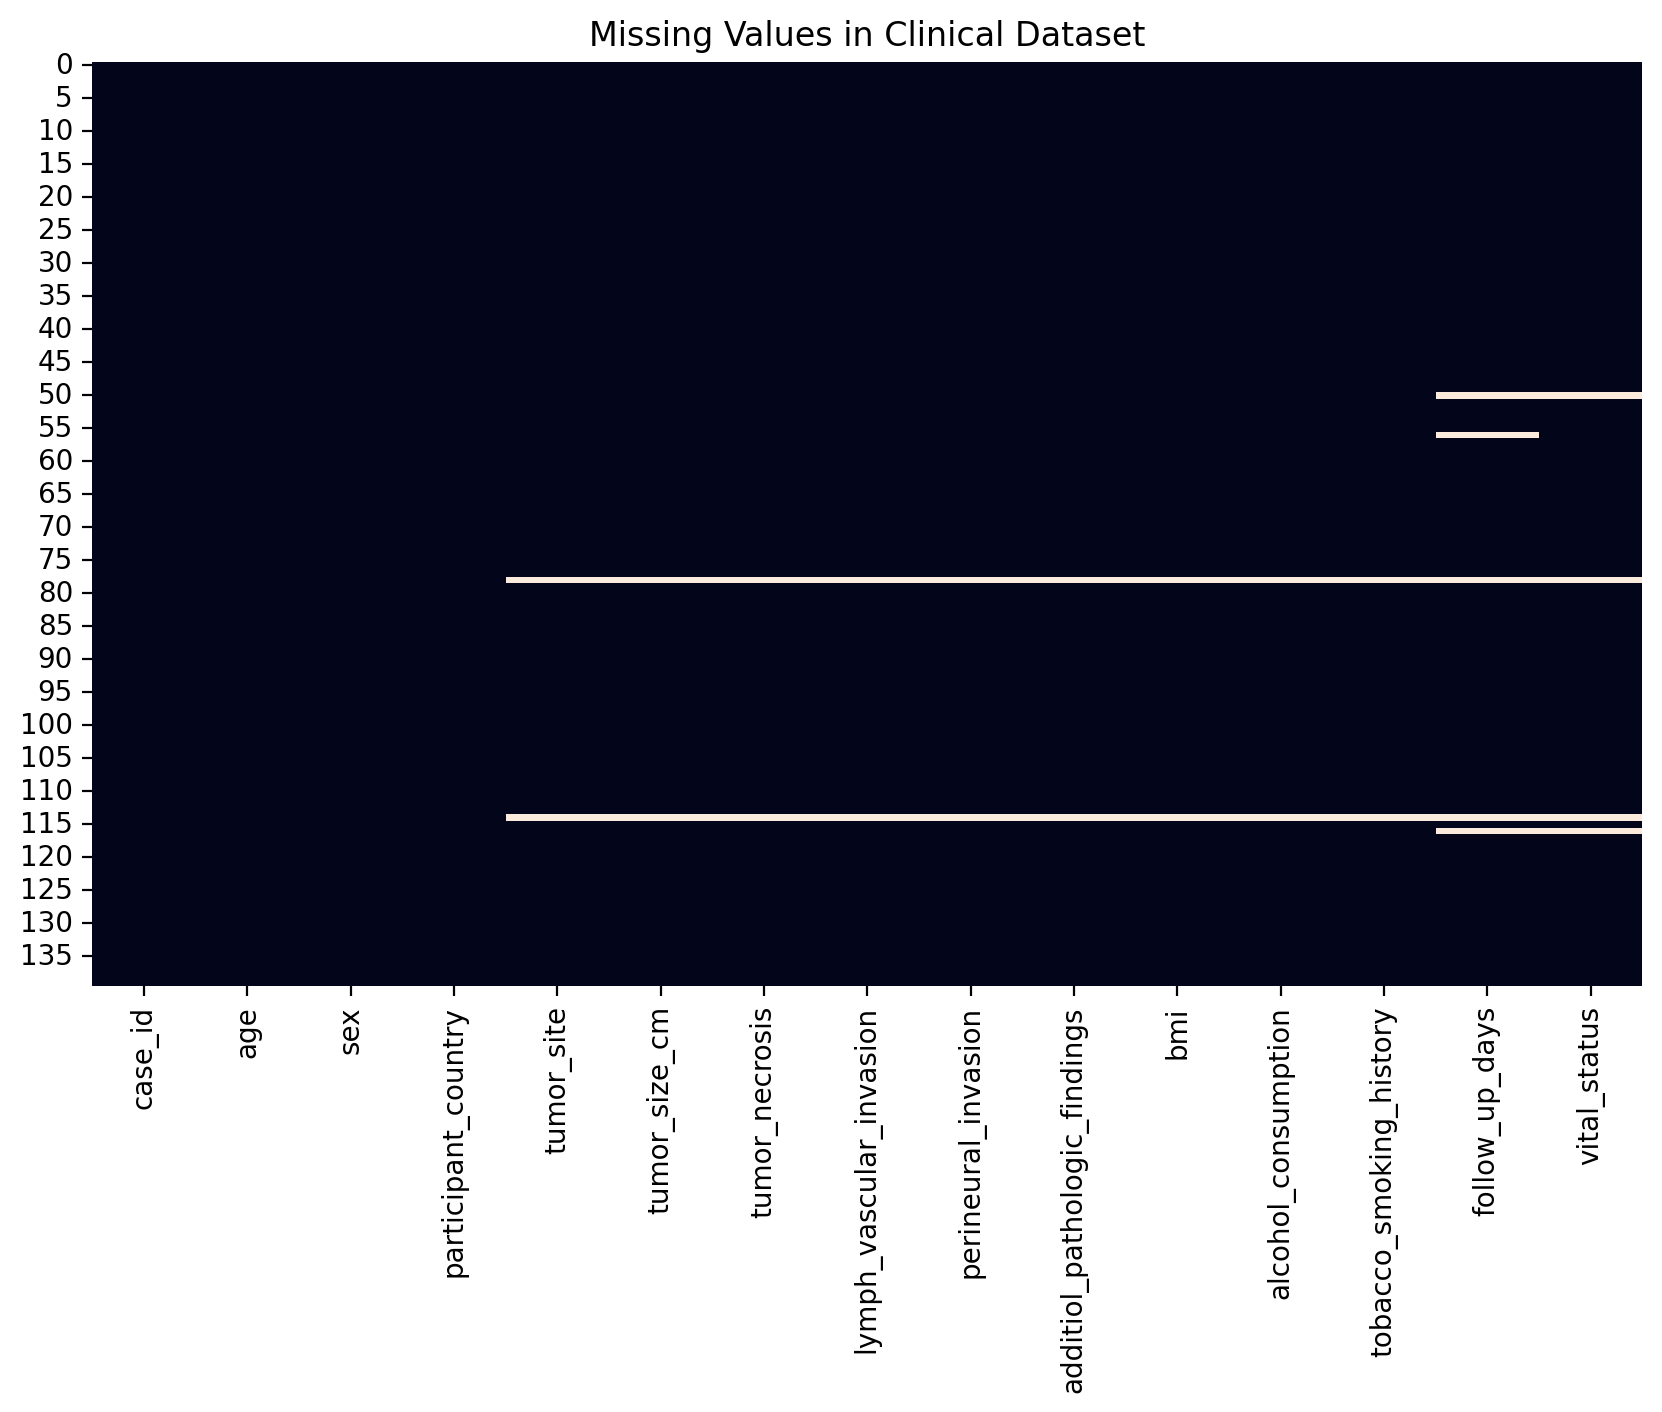

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(clinical.isnull(), cbar=False)
plt.title("Missing Values in Clinical Dataset")
plt.show()

In [13]:
clinical[numeric_cols] = clinical[numeric_cols].fillna(clinical[numeric_cols].mean())
for col in categorical_cols:
    clinical[col] = clinical[col].fillna(clinical[col].mode()[0])
clinical.isna().sum()

NameError: name 'numeric_cols' is not defined

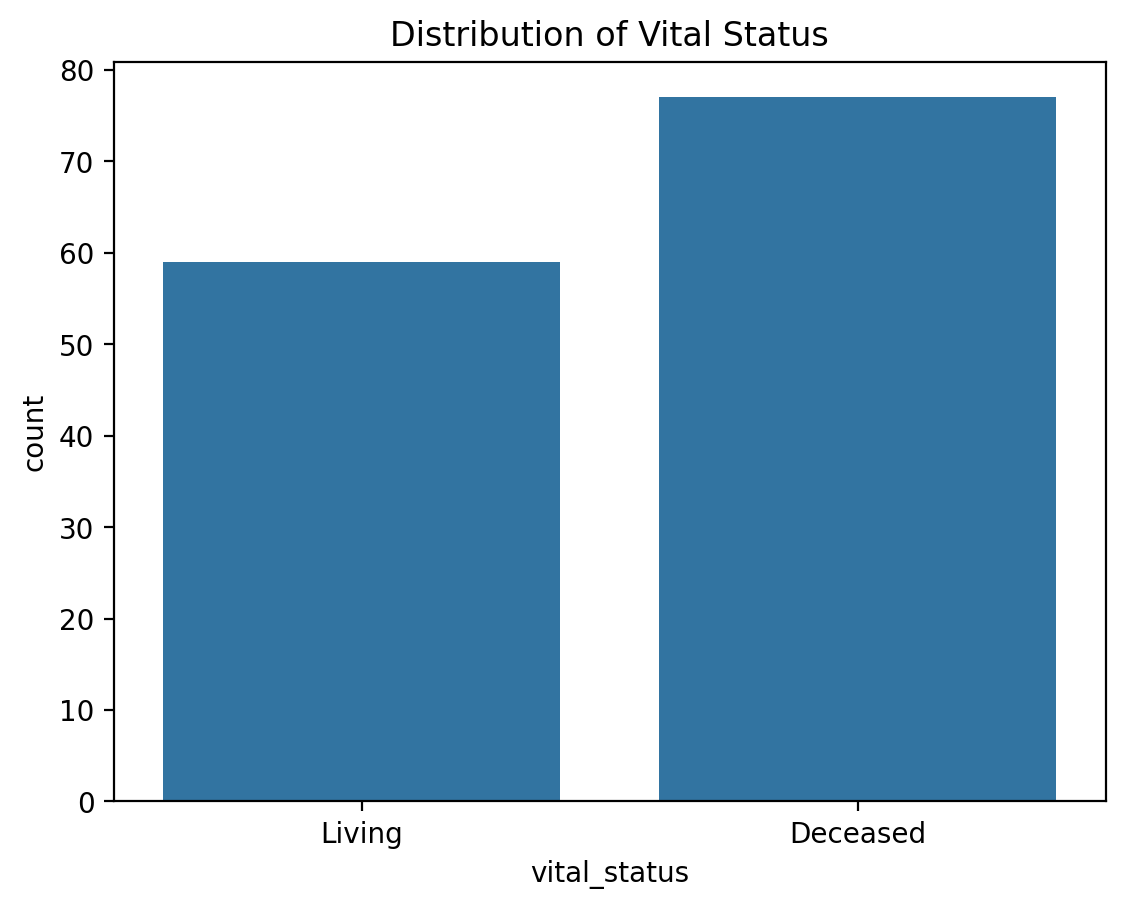

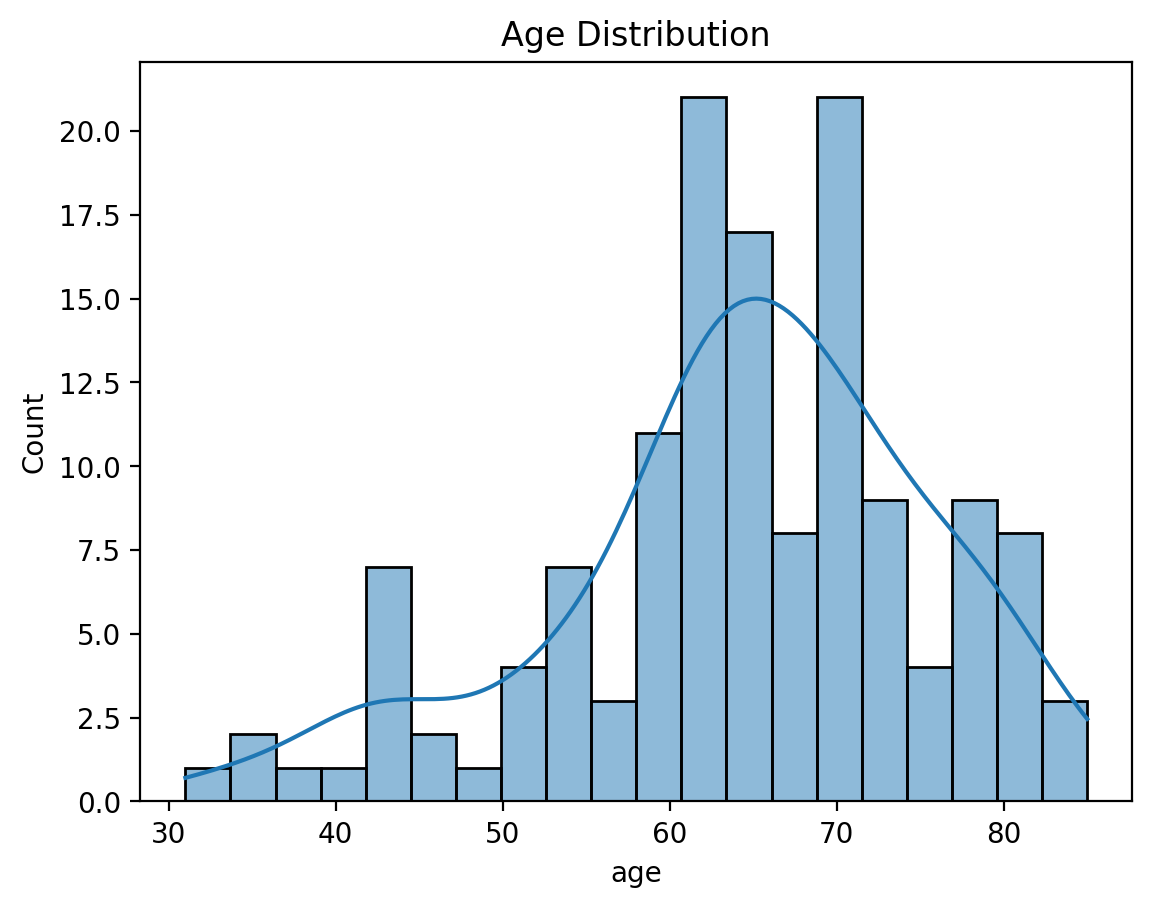

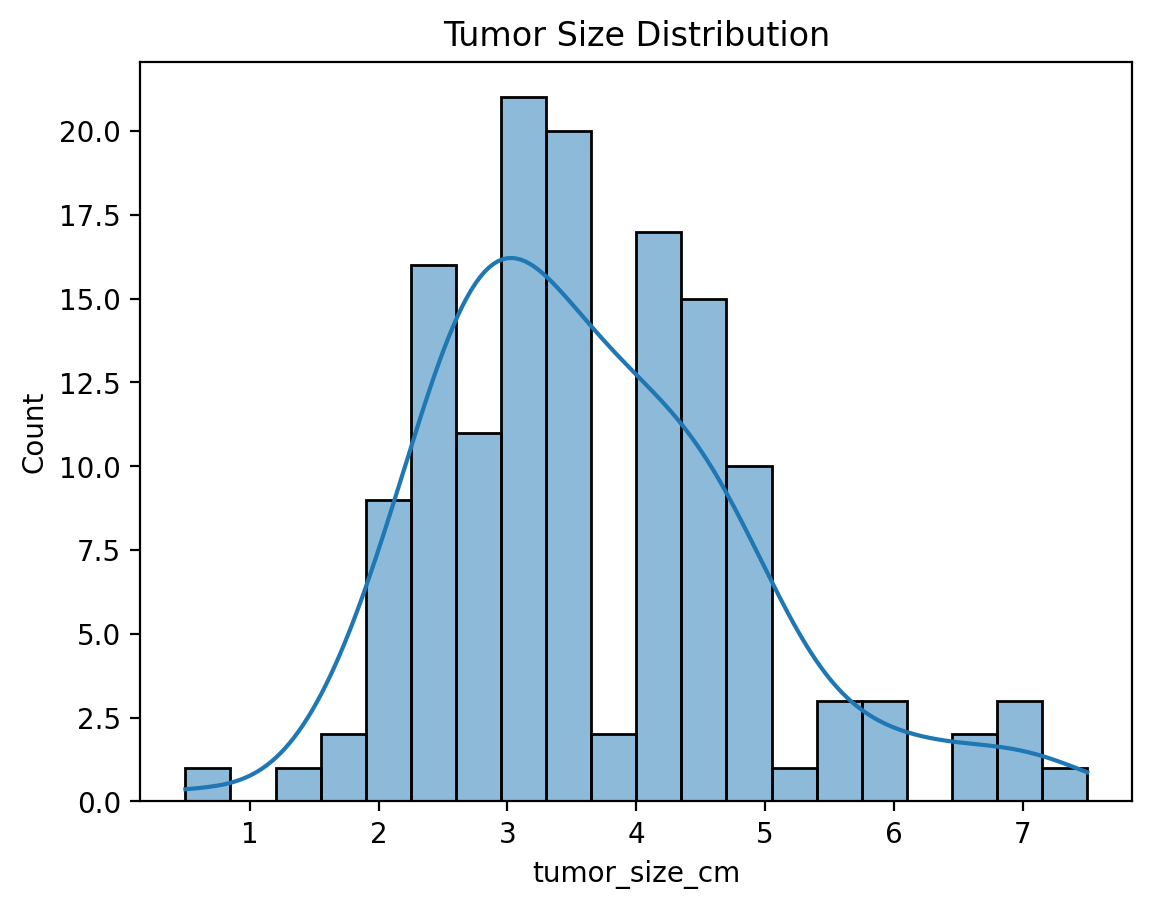

In [16]:
# Vital status distribution
sns.countplot(data=clinical, x='vital_status')
plt.title("Distribution of Vital Status")
plt.show()

# Age distribution
sns.histplot(clinical['age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.show()

# Tumor size distribution
sns.histplot(clinical['tumor_size_cm'].dropna(), kde=True, bins=20)
plt.title("Tumor Size Distribution")
plt.show()

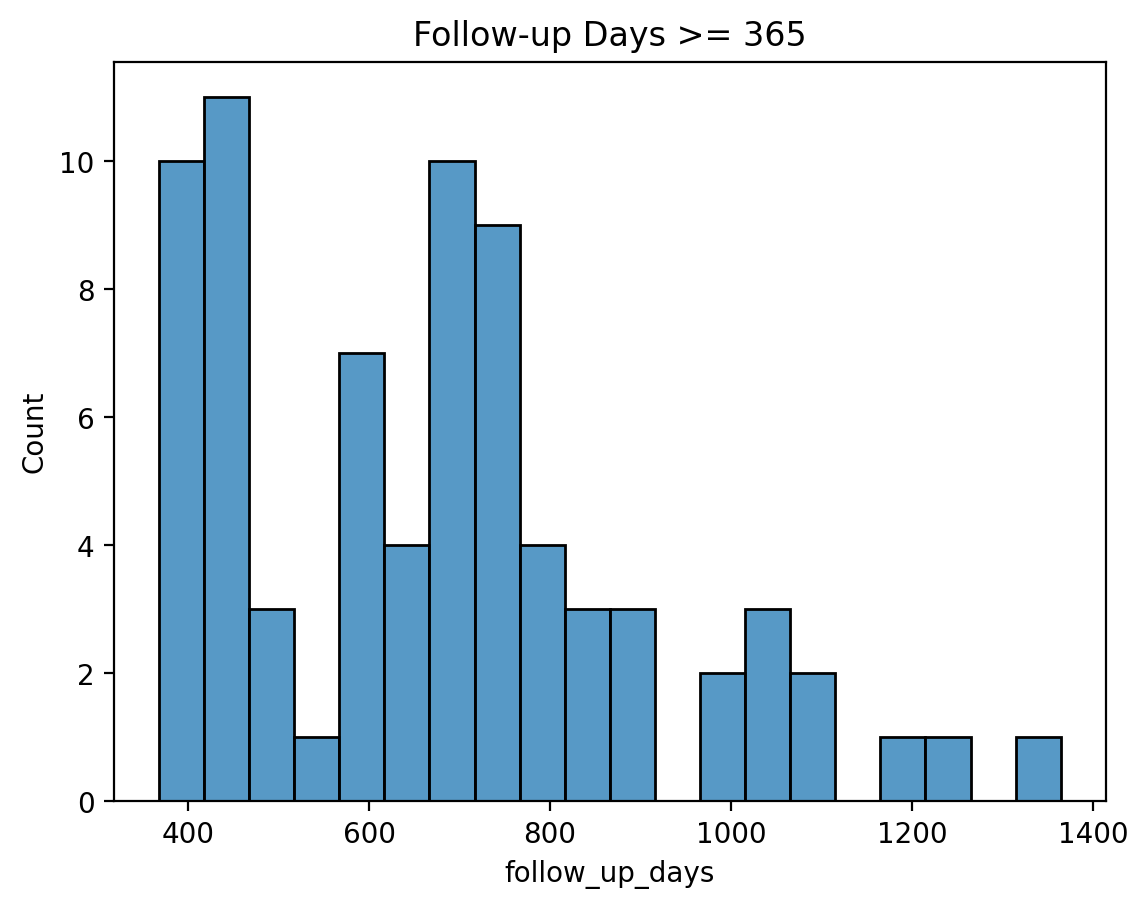

In [19]:
threshold_days = 365
clinical_filtered = clinical[clinical['follow_up_days'] >= threshold_days].copy()

sns.histplot(clinical_filtered['follow_up_days'], bins=20)
plt.title(f"Follow-up Days >= {threshold_days}")
plt.show()

In [21]:
# Identify types
numeric_cols = clinical.select_dtypes(include=["int64", "float64"]).columns
categorical_cols =  clinical.select_dtypes(include=["object", "category"]).columns

## Random Forest classification

In [26]:
threshold_days = 365  # e.g., 1 year
clinical_filtered = clinical[clinical['follow_up_days'] >= threshold_days].copy()


In [28]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['sex', 'participant_country', 'tumor_site', 'tumor_necrosis', 
                    'lymph_vascular_invasion', 'perineural_invasion', 'additiol_pathologic_findings',
                    'alcohol_consumption', 'tobacco_smoking_history']

for col in categorical_cols:
    clinical_filtered[col] = LabelEncoder().fit_transform(clinical_filtered[col].astype(str))


In [30]:
X = clinical_filtered.drop(columns=['case_id', 'vital_status','follow_up_days'])
y = clinical_filtered['vital_status']  # assuming it's 0/1 or Alive/Dead


In [32]:
y = LabelEncoder().fit_transform(y)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.67      0.67      0.67         9

    accuracy                           0.60        15
   macro avg       0.58      0.58      0.58        15
weighted avg       0.60      0.60      0.60        15



In [38]:
y_prob = clf.predict_proba(X_test)[:, 1]  # probability of "1" (dead)
custom_threshold = 0.6
y_pred_custom = (y_prob >= custom_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.75      0.67      0.71         9

    accuracy                           0.67        15
   macro avg       0.66      0.67      0.66        15
weighted avg       0.68      0.67      0.67        15



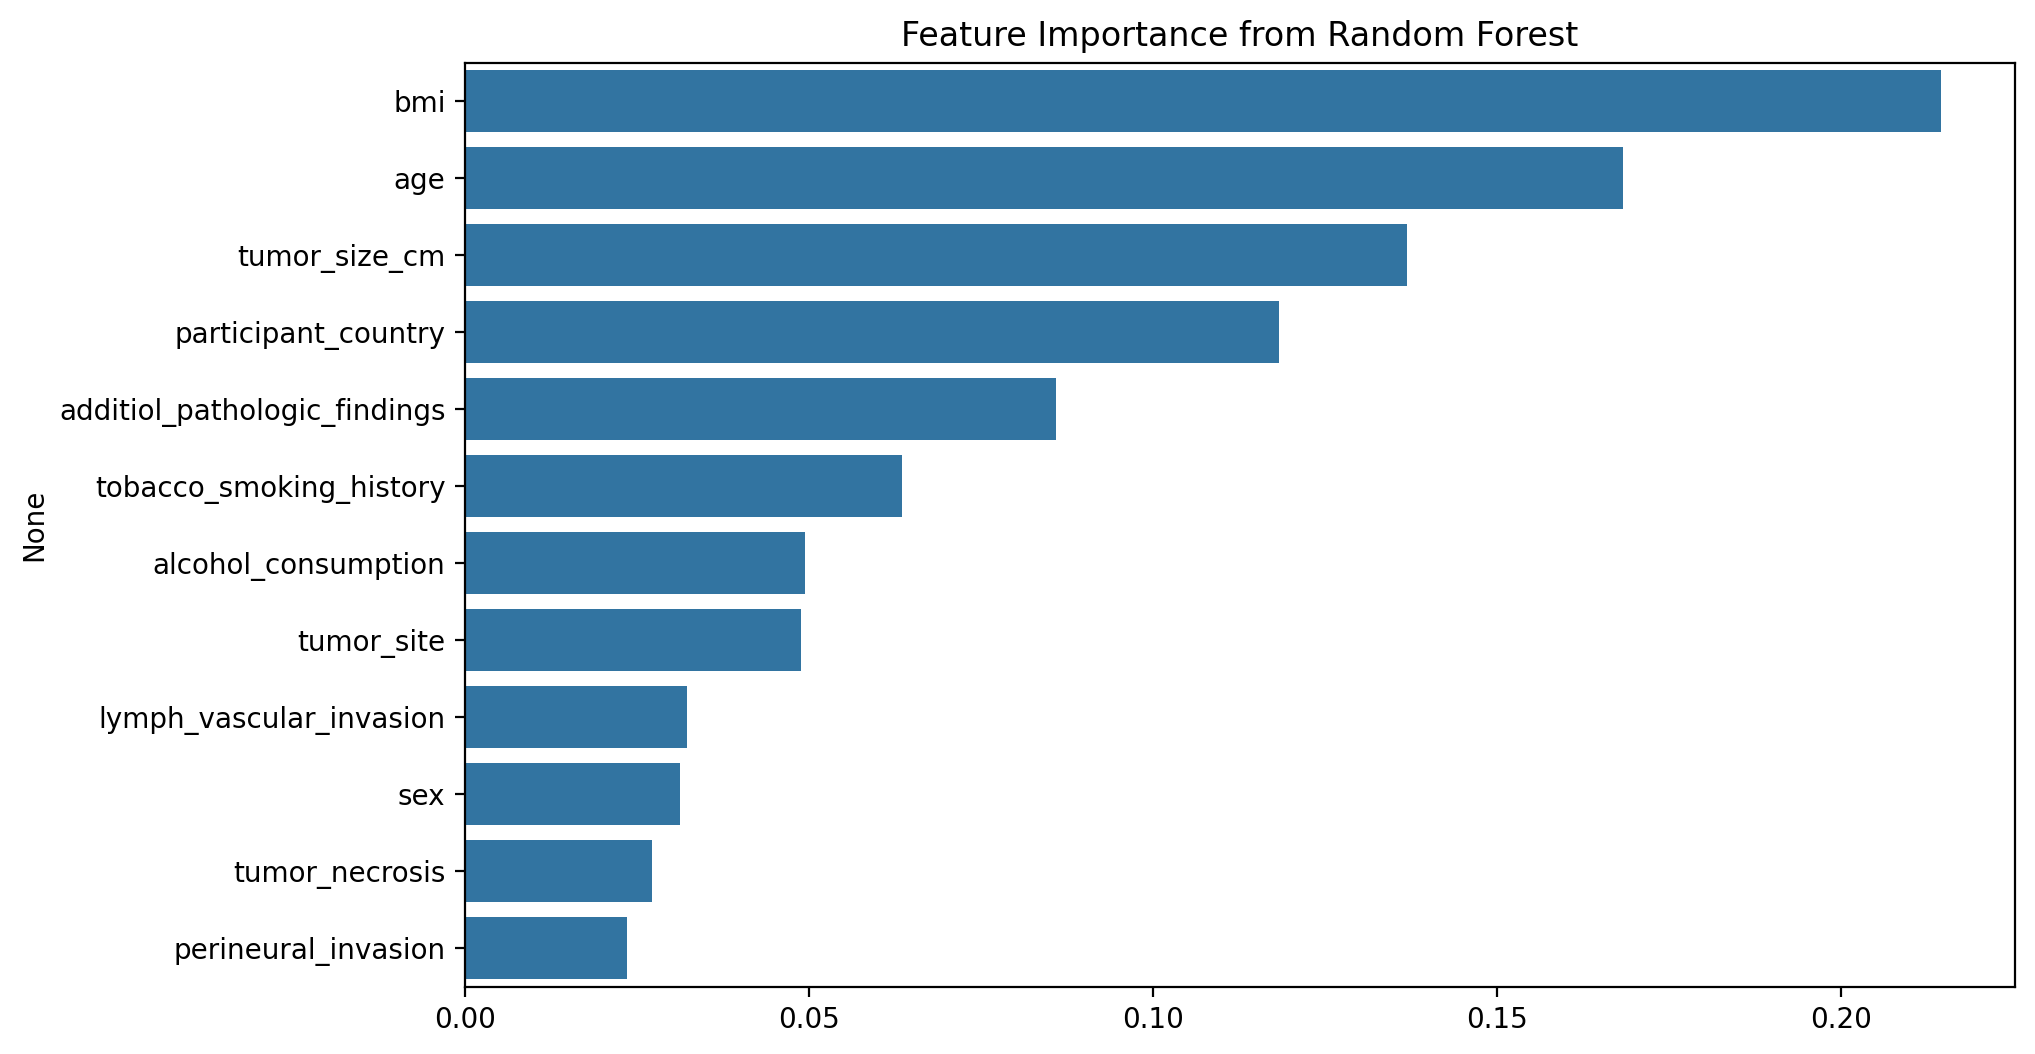

In [40]:
importances = clf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance from Random Forest")
plt.show()


## KNN 

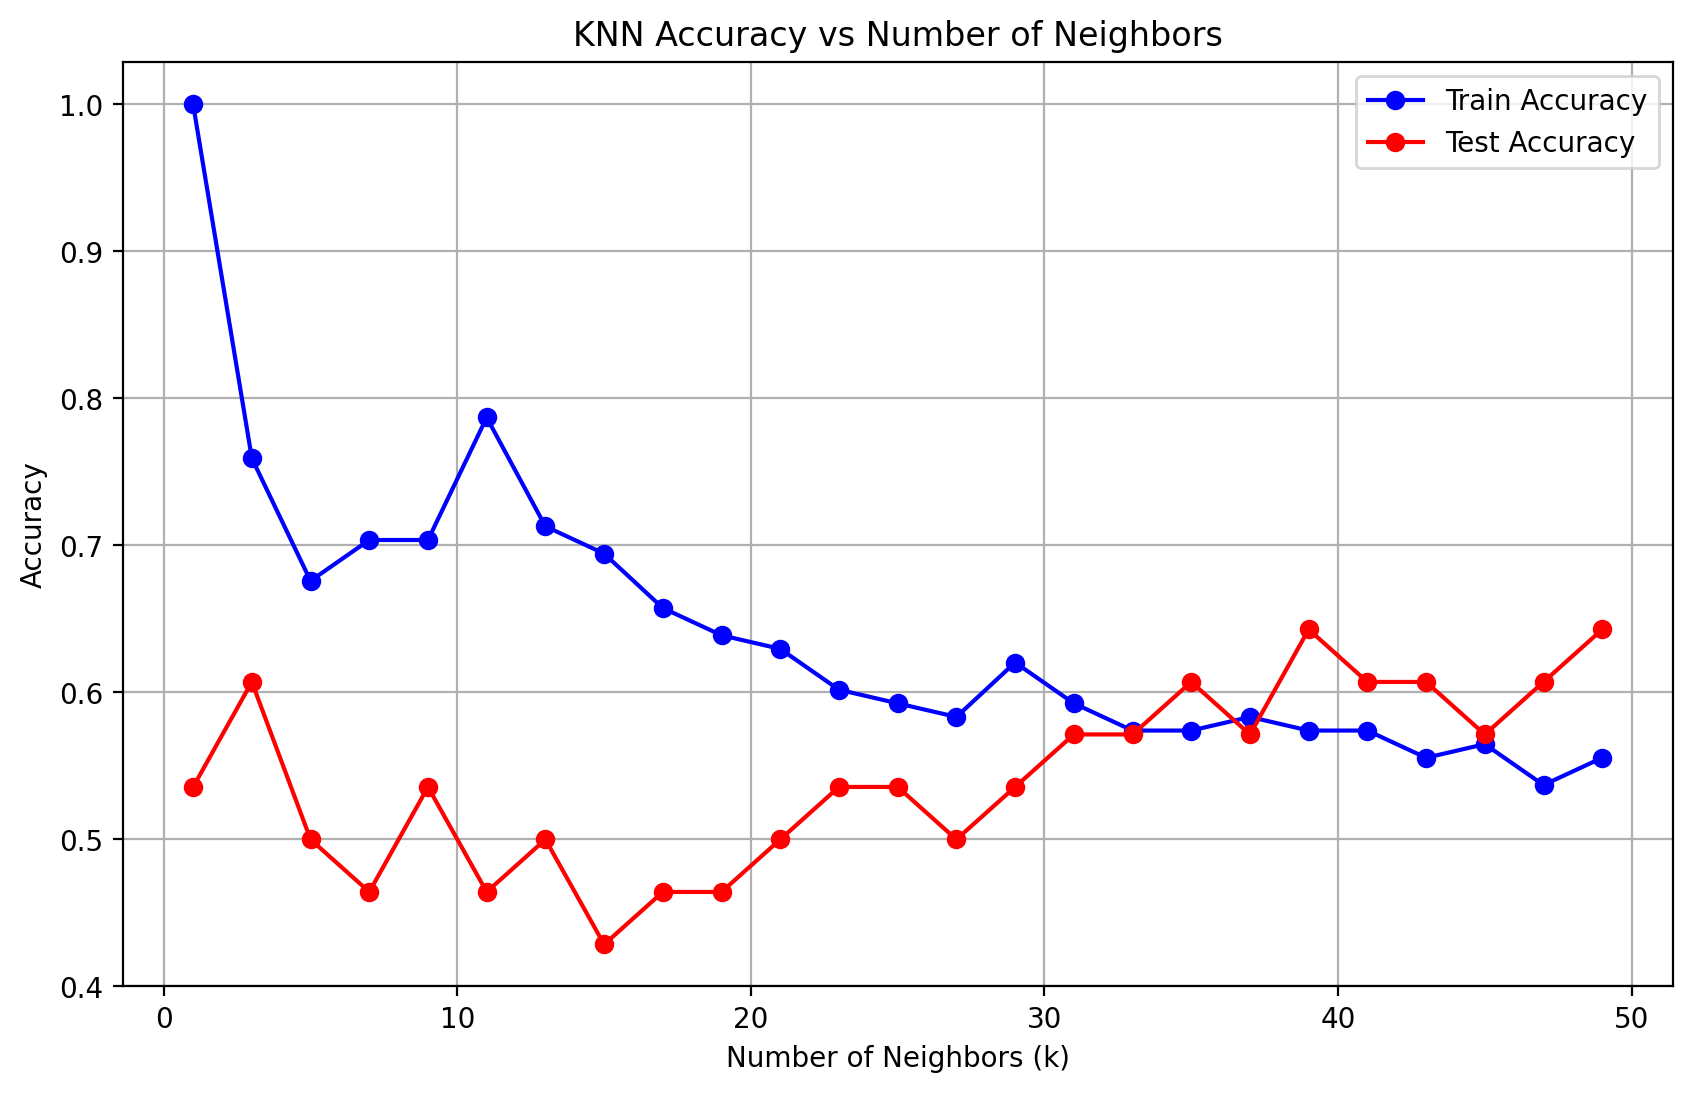

Best k: 39
              precision    recall  f1-score   support

           0       0.62      0.94      0.75        16
           1       0.75      0.25      0.38        12

    accuracy                           0.64        28
   macro avg       0.69      0.59      0.56        28
weighted avg       0.68      0.64      0.59        28



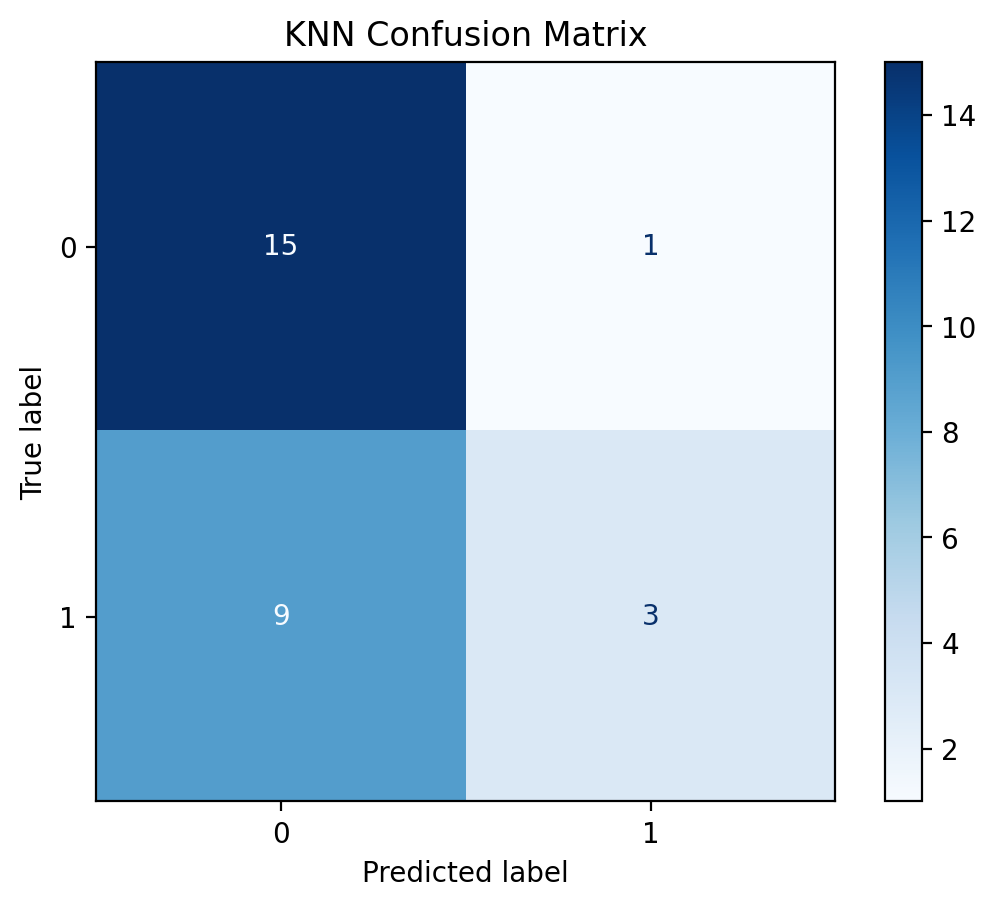

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer


# 1: Load and preprocess the data 

clinical = pd.read_csv("clinical.csv", sep=";", decimal=",", engine="python")

cols_to_drop = [
    'race', 'histology_diagnosis', 'pathologic_staging_regiol_lymph_nodes_pn',
    'pathologic_staging_primary_tumor_pt', 'pathologic_staging_distant_metastasis_pm',
    'clinical_staging_distant_metastasis_cm', 'residual_tumor',
    'tumor_stage_pathological', 'is_this_patient_lost_to_follow_up',
    'cause_of_death'
]
clinical = clinical.drop(columns=cols_to_drop, errors='ignore')

# 2: Split known and unknown targets

train_data = clinical[clinical['vital_status'].notna()]
predict_data = clinical[clinical['vital_status'].isna()]

# 3: Prepare features and target

X_train_full = train_data.drop(columns=['case_id', 'vital_status', 'follow_up_days'])
y_train_full = LabelEncoder().fit_transform(train_data['vital_status'])  # 0=Deceased, 1=Living

X_predict = predict_data.drop(columns=['case_id', 'vital_status', 'follow_up_days'])


# 4: Identify numeric and categorical features

numeric_cols = ['age', 'tumor_size_cm', 'bmi']
categorical_cols = [col for col in X_train_full.columns if col not in numeric_cols]


# 5: Impute missing values

# Numeric: median
num_imputer = SimpleImputer(strategy='median')
X_train_full[numeric_cols] = num_imputer.fit_transform(X_train_full[numeric_cols])
if not X_predict.empty:
    X_predict[numeric_cols] = num_imputer.transform(X_predict[numeric_cols])

# Categorical: most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_full[categorical_cols] = cat_imputer.fit_transform(X_train_full[categorical_cols])
if not X_predict.empty:
    X_predict[categorical_cols] = cat_imputer.transform(X_predict[categorical_cols])


# 6: Encode categorical features (one-hot)

X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols)
X_predict = pd.get_dummies(X_predict, columns=categorical_cols)
X_predict = X_predict.reindex(columns=X_train_full.columns, fill_value=0)


# 7: Scale numeric features

scaler = StandardScaler()
X_train_full[numeric_cols] = scaler.fit_transform(X_train_full[numeric_cols])
if not X_predict.empty:
    X_predict[numeric_cols] = scaler.transform(X_predict[numeric_cols])


# 8: Train/test split for evaluation

X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)


# 9: Hyperparameter tuning

score_train = []
score_test = []

neighbors = range(1, min(50, len(X_train)), 2)

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    
    score_train.append(metrics.accuracy_score(y_train, y_pred_train))
    score_test.append(metrics.accuracy_score(y_test, y_pred_test))

# Plot Accuracy vs Neighbors
plt.figure(figsize=(10,6))
plt.plot(neighbors, score_train, label='Train Accuracy', marker='o', color='blue')
plt.plot(neighbors, score_test, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

best_k = neighbors[np.argmax(score_test)]
print("Best k:", best_k)


# 10: Train final KNN

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

y_pred = knn_final.predict(X_test)

# Classification report
print(metrics.classification_report(y_test, y_pred))

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_final.classes_)
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()







## Prediction

In [51]:


#  Predict missing vital_status
if not X_predict.empty:
    y_pred_missing = knn_final.predict(X_predict)
    predict_data['vital_status_pred'] = y_pred_missing
    print(predict_data[['case_id','vital_status_pred']].head())

       case_id  vital_status_pred
50   C3L-03395                  1
78   C3N-00709                  0
114  C3N-03039                  0
116  C3N-03069                  0


/var/folders/n5/8_21j65x5s14d8k6sc6vc5300000gn/T/ipykernel_77583/2256935023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['vital_status_pred'] = y_pred_missing


## feature importance

<Figure size 640x480 with 0 Axes>

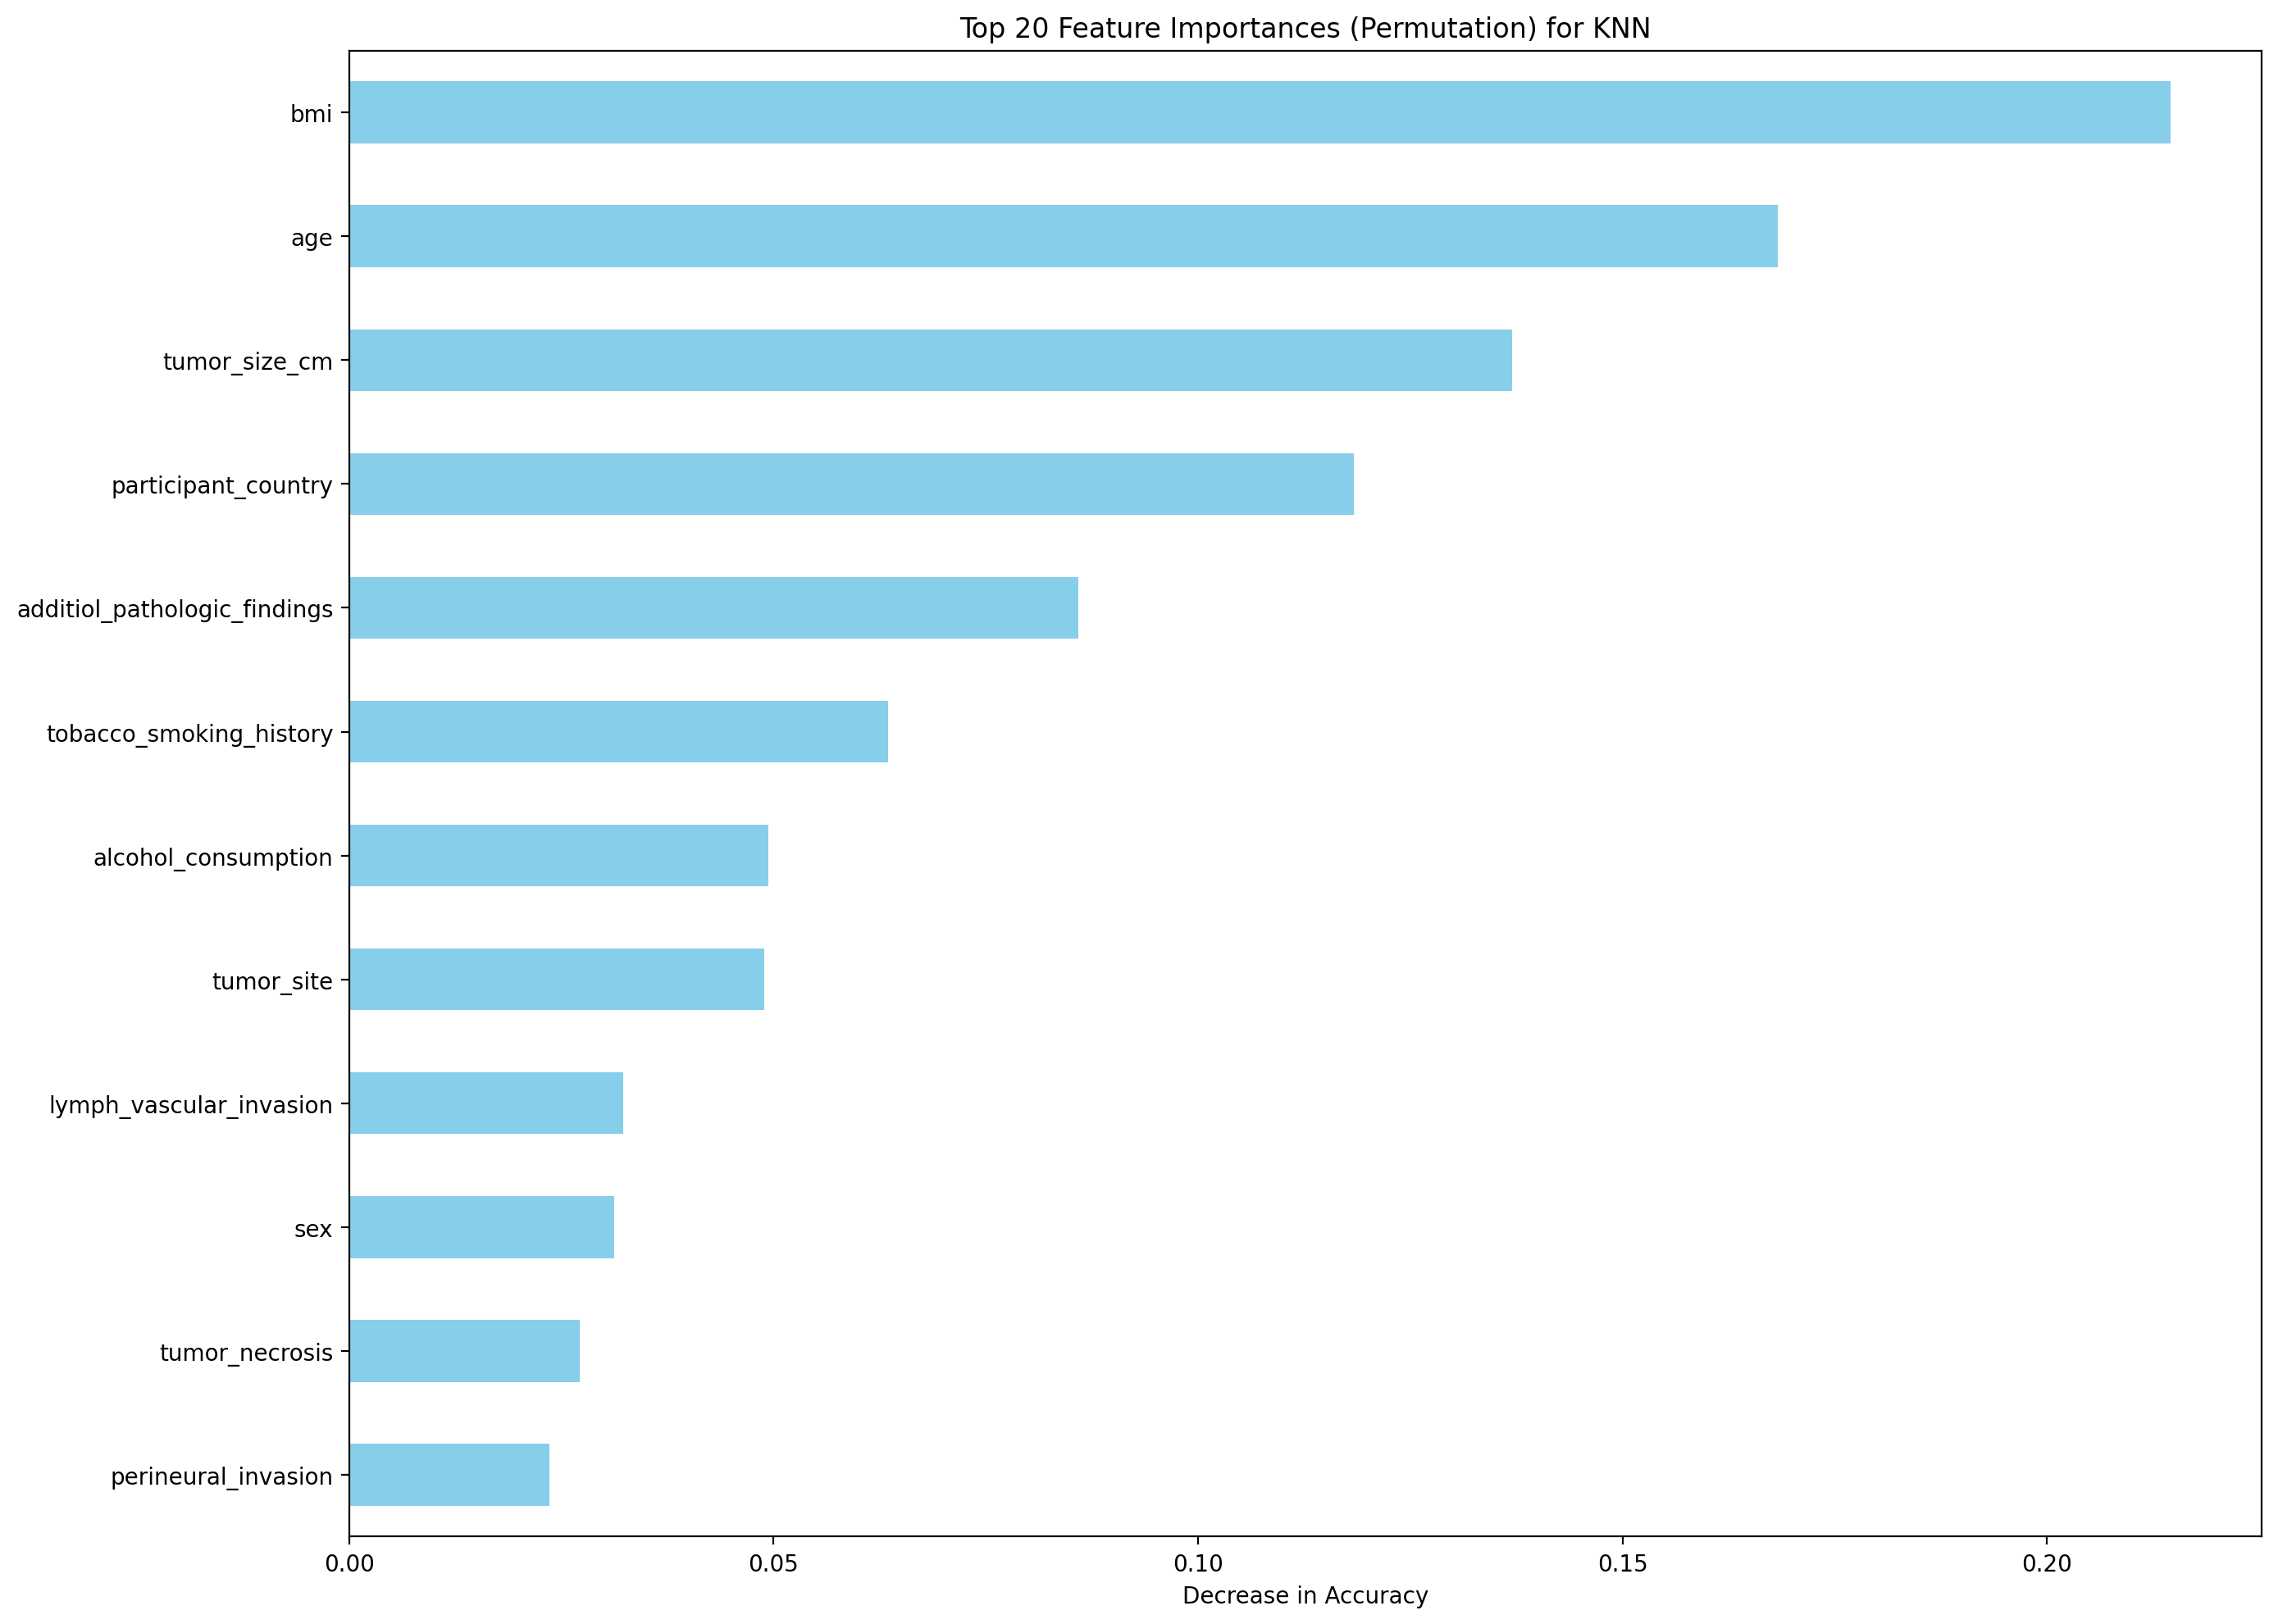

In [59]:
# Sort and keep top 20 features
top_n = 20
feat_imp_sorted = feat_imp.sort_values(ascending=True).tail(top_n)

# Horizontal bar plot
plt.figure(figsize=(14,10))
feat_imp_sorted.plot(kind='barh', color='skyblue')
plt.xlabel("Decrease in Accuracy")
plt.title(f"Top {top_n} Feature Importances (Permutation) for KNN")
plt.tight_layout()
plt.savefig("example_plot.png", dpi=300, bbox_inches='tight')  # PNG file

plt.show()

In [57]:
plt.savefig("example_plot.png", dpi=300, bbox_inches='tight')  # PNG file


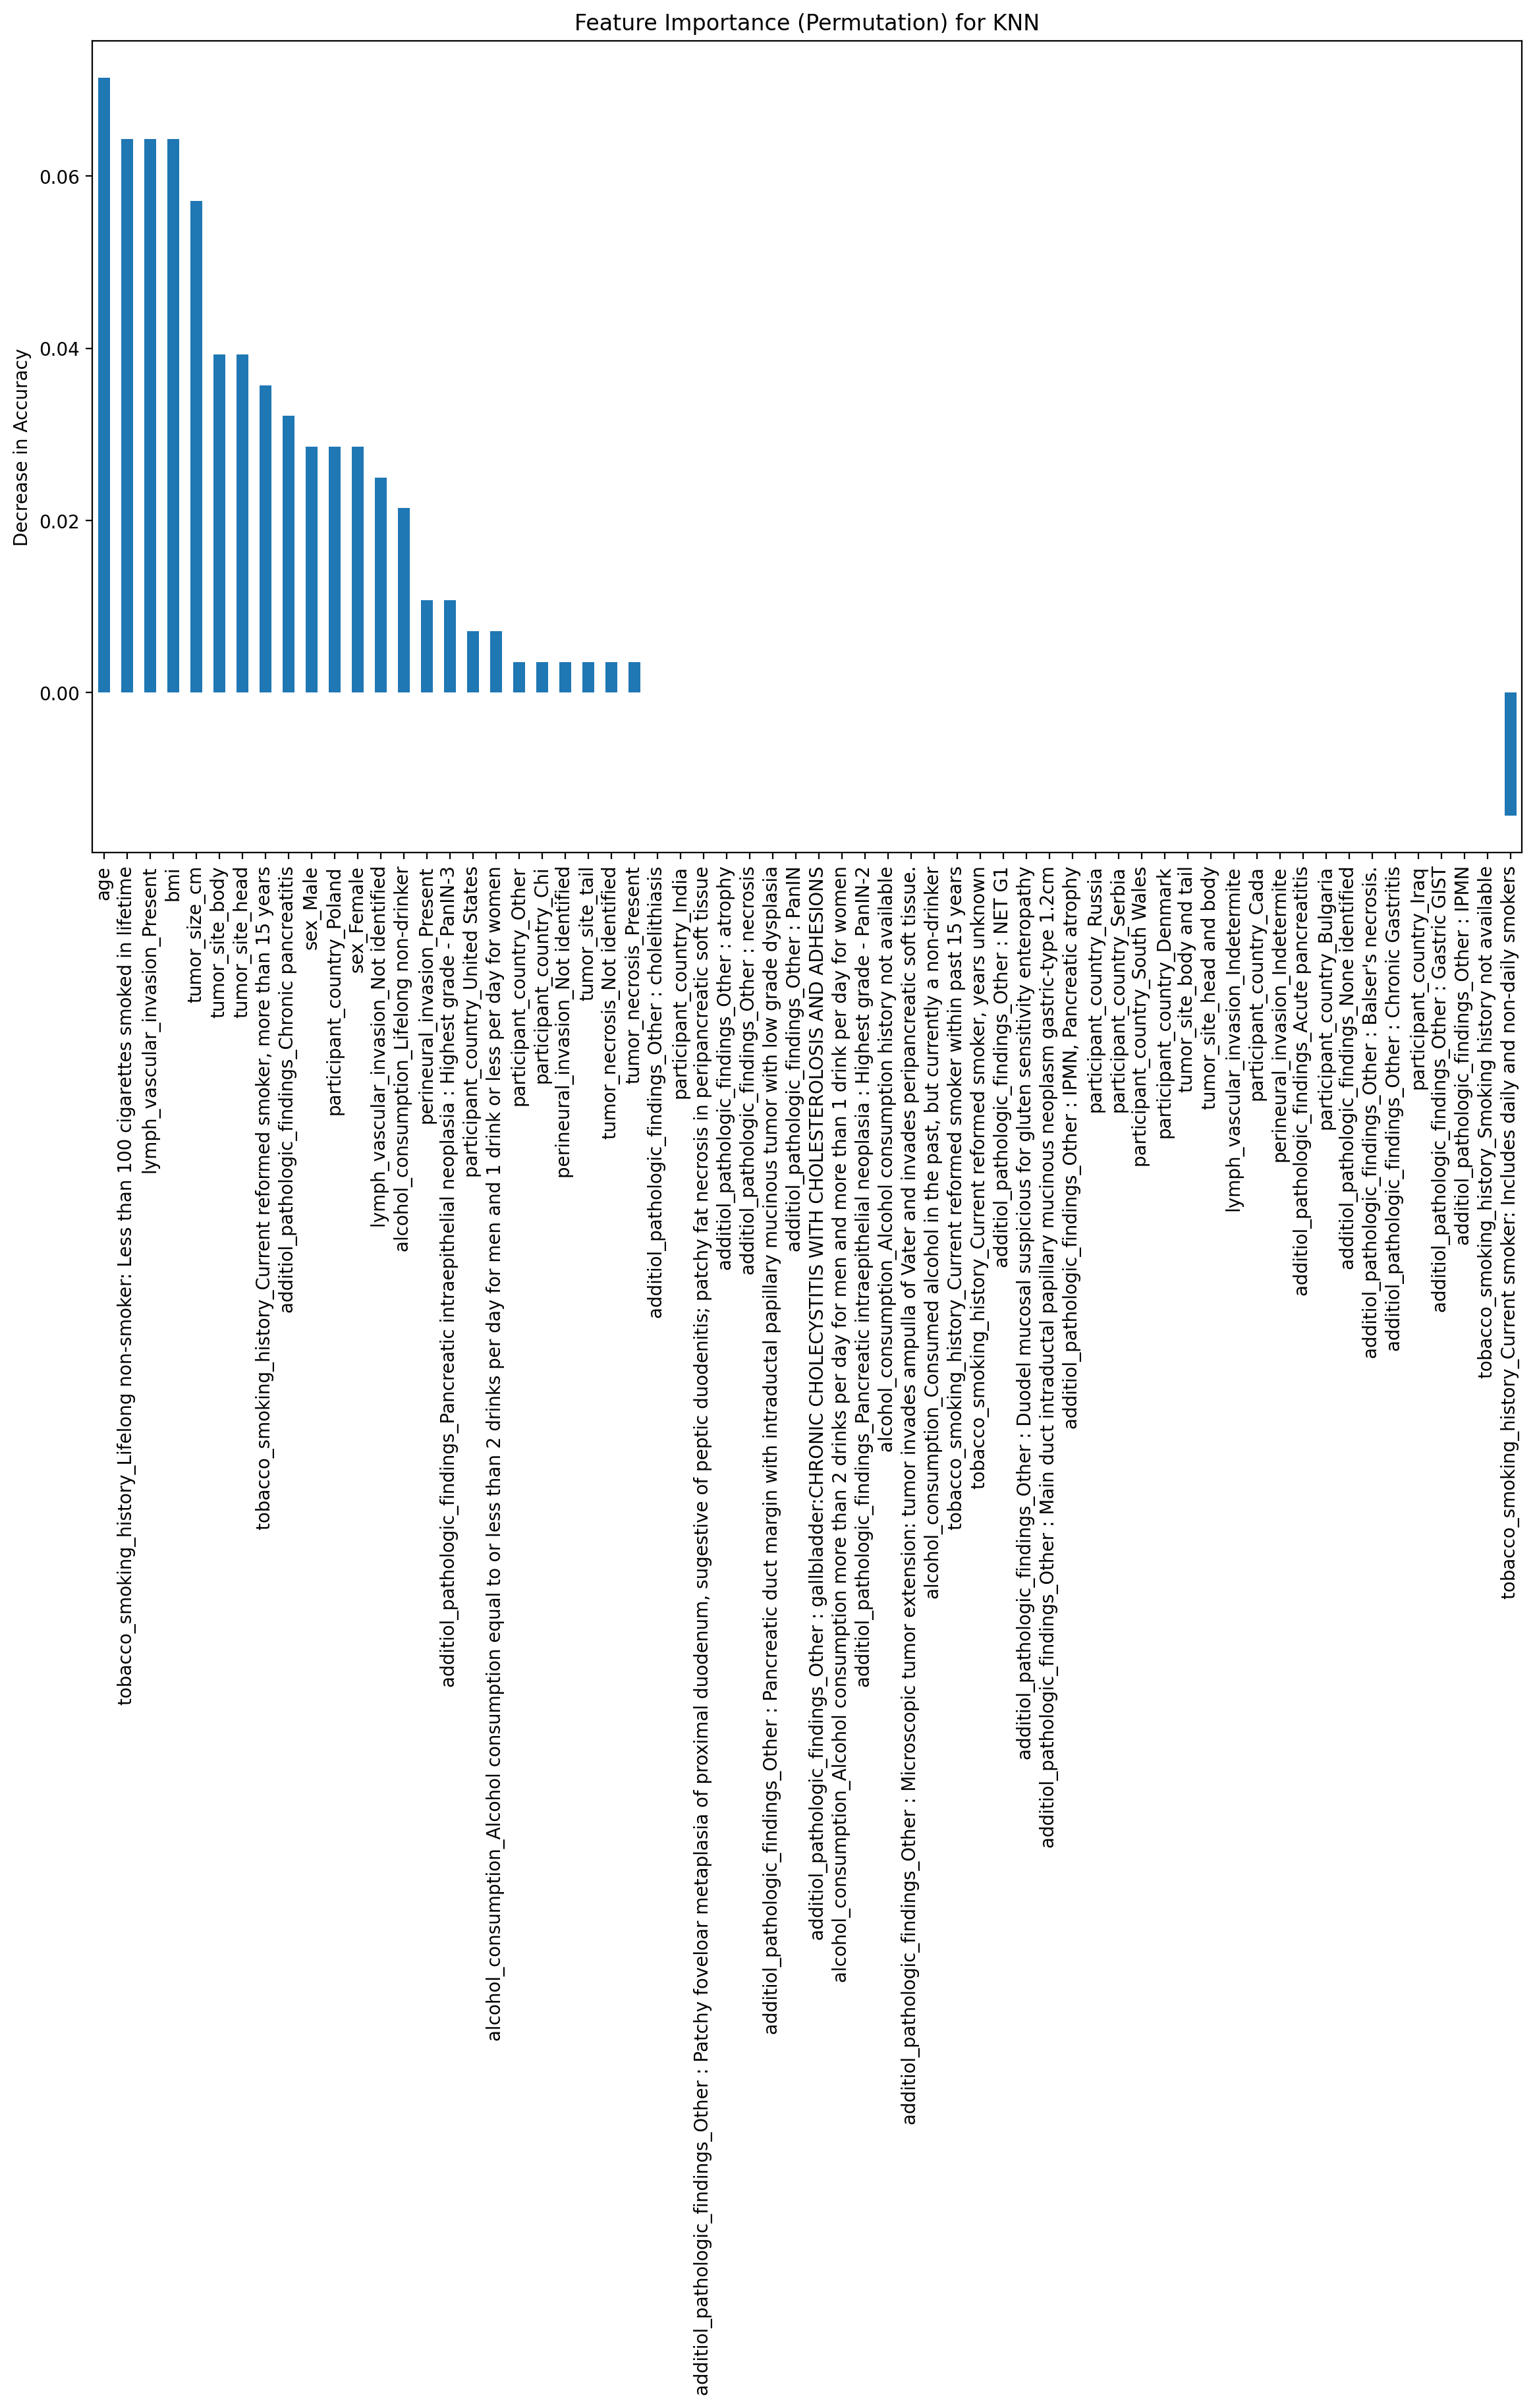

In [407]:
from sklearn.inspection import permutation_importance

# Use the trained final KNN
result = permutation_importance(knn_final, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Create a Series with feature importance
feat_imp = pd.Series(result.importances_mean, index=X_train_full.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(14,8))
feat_imp.plot(kind='bar')
plt.title("Feature Importance (Permutation) for KNN")
plt.ylabel("Decrease in Accuracy")
plt.show()